<a href="https://colab.research.google.com/github/SainiThapa/SEMINAR-and-RESEARCH/blob/main/Air_Quality_Index_and_Domestic_fuel_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


# STEP 1: DATA ACQUISITION AND LOADING\

In [3]:
print("\n[STEP 1] DATA ACQUISITION")
print("-" * 80)

# Load the datasets
print("Loading PM 2.5 concentration data...")
pm25_df = pd.read_csv('Concenterations of fine particulate matter (PM 2.5) 2015_19.csv')
print(f"✓ PM 2.5 data loaded: {pm25_df.shape[0]} rows, {pm25_df.shape[1]} columns")

print("\nLoading cooking fuel data...")
fuel_df = pd.read_csv('Proportion of population with primary reliance on fuels and technologies for cooking by fuel type (%).csv')
print(f"✓ Fuel data loaded: {fuel_df.shape[0]} rows, {fuel_df.shape[1]} columns")

# Display basic information
print("\n" + "=" * 80)
print("PM 2.5 Dataset Preview:")
print("-" * 80)
print(pm25_df.head())
print("\nColumn names:", pm25_df.columns.tolist())

print("\n" + "=" * 80)
print("Cooking Fuel Dataset Preview:")
print("-" * 80)
print(fuel_df.head())
print("\nColumn names:", fuel_df.columns.tolist())



[STEP 1] DATA ACQUISITION
--------------------------------------------------------------------------------
Loading PM 2.5 concentration data...
✓ PM 2.5 data loaded: 1930 rows, 34 columns

Loading cooking fuel data...
✓ Fuel data loaded: 2880 rows, 34 columns

PM 2.5 Dataset Preview:
--------------------------------------------------------------------------------
  IndicatorCode                                          Indicator ValueType  \
0       SDGPM25  Concentrations of fine particulate matter (PM2.5)      text   
1       SDGPM25  Concentrations of fine particulate matter (PM2.5)      text   
2       SDGPM25  Concentrations of fine particulate matter (PM2.5)      text   
3       SDGPM25  Concentrations of fine particulate matter (PM2.5)      text   
4       SDGPM25  Concentrations of fine particulate matter (PM2.5)      text   

  ParentLocationCode ParentLocation Location type SpatialDimValueCode  \
0                AMR       Americas       Country                 TTO   
1     

# STEP 2: DATA CLEANING AND PREPARATION

In [4]:
print("\n\n[STEP 2] DATA CLEANING AND PREPARATION")
print("-" * 80)

# Clean PM 2.5 data
print("\nCleaning PM 2.5 data...")
pm25_clean = pm25_df[['Location', 'Period', 'Dim1', 'FactValueNumeric',
                       'ParentLocation']].copy()
pm25_clean.columns = ['Country', 'Year', 'Residence_Type', 'PM25_Concentration',
                      'Region']
pm25_clean = pm25_clean[pm25_clean['Year'] == 2019]  # Focus on 2019
pm25_clean = pm25_clean.dropna(subset=['PM25_Concentration'])
print(f"✓ PM 2.5 cleaned: {pm25_clean.shape[0]} records for 2019")

# Clean fuel data
print("\nCleaning cooking fuel data...")
fuel_clean = fuel_df[['Location', 'Period', 'Dim1', 'Dim2', 'FactValueNumeric',
                       'ParentLocation']].copy()
fuel_clean.columns = ['Country', 'Year', 'Residence_Type', 'Fuel_Type',
                     'Percentage', 'Region']
fuel_clean = fuel_clean[fuel_clean['Year'] == 2019]  # Focus on 2019
fuel_clean = fuel_clean.dropna(subset=['Percentage'])
print(f"✓ Fuel data cleaned: {fuel_clean.shape[0]} records for 2019")

# Categorize fuels as clean vs unclean
print("\nCategorizing fuels...")
clean_fuels = ['Gas', 'Electricity']
unclean_fuels = ['Biomass', 'Kerosene', 'Charcoal', 'Coal']

fuel_clean['Fuel_Category'] = fuel_clean['Fuel_Type'].apply(
    lambda x: 'Clean' if x in clean_fuels else
             ('Unclean' if x in unclean_fuels else 'Other')
)

# Aggregate fuel data by country and residence type
print("\nAggregating fuel usage by category...")
fuel_agg = fuel_clean.groupby(['Country', 'Residence_Type', 'Fuel_Category',
                                'Region'])['Percentage'].sum().reset_index()

# Pivot to get clean and unclean percentages
fuel_pivot = fuel_agg.pivot_table(
    index=['Country', 'Residence_Type', 'Region'],
    columns='Fuel_Category',
    values='Percentage',
    fill_value=0
).reset_index()

print(f"✓ Fuel data aggregated: {fuel_pivot.shape[0]} records")




[STEP 2] DATA CLEANING AND PREPARATION
--------------------------------------------------------------------------------

Cleaning PM 2.5 data...
✓ PM 2.5 cleaned: 386 records for 2019

Cleaning cooking fuel data...
✓ Fuel data cleaned: 2880 records for 2019

Categorizing fuels...

Aggregating fuel usage by category...
✓ Fuel data aggregated: 480 records


# STEP 3: MERGE DATASETS

In [5]:
print("\n\n[STEP 3] MERGING DATASETS")
print("-" * 80)

# Merge PM 2.5 with fuel data
merged_df = pd.merge(
    pm25_clean,
    fuel_pivot,
    on=['Country', 'Residence_Type'],
    how='inner'
)

print(f"✓ Datasets merged: {merged_df.shape[0]} records with both PM 2.5 and fuel data")
print(f"✓ Countries covered: {merged_df['Country'].nunique()}")
print(f"✓ Regions covered: {merged_df['Region_x'].nunique()}")

# Display merged data summary
print("\nMerged Dataset Summary:")
print(merged_df.describe())



[STEP 3] MERGING DATASETS
--------------------------------------------------------------------------------
✓ Datasets merged: 312 records with both PM 2.5 and fuel data
✓ Countries covered: 157
✓ Regions covered: 6

Merged Dataset Summary:
         Year  PM25_Concentration       Clean     Unclean
count   312.0          312.000000  312.000000  312.000000
mean   2019.0           23.237212   55.478846   38.787660
std       0.0           13.837272   38.161727   38.567614
min    2019.0            5.200000    0.000000    0.000000
25%    2019.0           12.637500   13.875000    1.900000
50%    2019.0           19.800000   68.650000   22.950000
75%    2019.0           32.200000   92.725000   80.350000
max    2019.0           75.190000   99.400000   99.500000


# STEP 4: EXPLORATORY DATA ANALYSIS

In [6]:
print("\n\n[STEP 4] EXPLORATORY DATA ANALYSIS")
print("-" * 80)

# Calculate correlation
if 'Clean' in merged_df.columns and 'Unclean' in merged_df.columns:
    corr_clean = merged_df[['PM25_Concentration', 'Clean']].corr().iloc[0, 1]
    corr_unclean = merged_df[['PM25_Concentration', 'Unclean']].corr().iloc[0, 1]

    print(f"\nCorrelation Analysis:")
    print(f"  • Clean fuels vs PM 2.5: {corr_clean:.4f}")
    print(f"  • Unclean fuels vs PM 2.5: {corr_unclean:.4f}")

# Regional analysis
print("\n\nPM 2.5 Concentration by Region:")
regional_avg = merged_df.groupby('Region_x')['PM25_Concentration'].mean().sort_values(ascending=False)
for region, value in regional_avg.items():
    print(f"  • {region}: {value:.2f} μg/m³")




[STEP 4] EXPLORATORY DATA ANALYSIS
--------------------------------------------------------------------------------

Correlation Analysis:
  • Clean fuels vs PM 2.5: -0.1402
  • Unclean fuels vs PM 2.5: 0.1979


PM 2.5 Concentration by Region:
  • Eastern Mediterranean: 36.70 μg/m³
  • South-East Asia: 29.15 μg/m³
  • Africa: 29.11 μg/m³
  • Europe: 20.45 μg/m³
  • Western Pacific: 14.58 μg/m³
  • Americas: 13.55 μg/m³


# STEP 5: VISUALIZATIONS

**Visualization 1: PM 2.5 vs Clean Fuel Usage**

✓ Scatter plots saved as 'fuel_vs_pm25_scatter.png'


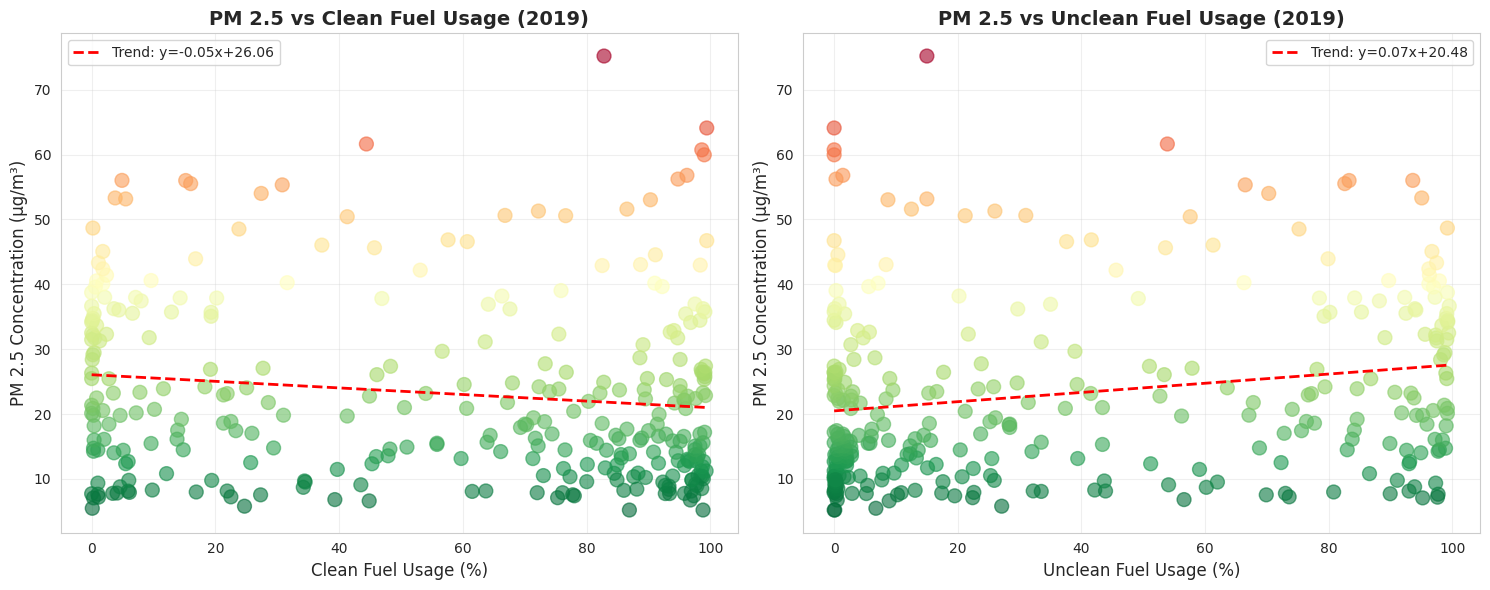

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

if 'Clean' in merged_df.columns:
    axes[0].scatter(merged_df['Clean'], merged_df['PM25_Concentration'],
                   alpha=0.6, c=merged_df['PM25_Concentration'],
                   cmap='RdYlGn_r', s=100)
    axes[0].set_xlabel('Clean Fuel Usage (%)', fontsize=12)
    axes[0].set_ylabel('PM 2.5 Concentration (μg/m³)', fontsize=12)
    axes[0].set_title('PM 2.5 vs Clean Fuel Usage (2019)', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)

    # Add trend line
    z = np.polyfit(merged_df['Clean'], merged_df['PM25_Concentration'], 1)
    p = np.poly1d(z)
    axes[0].plot(merged_df['Clean'].sort_values(),
                p(merged_df['Clean'].sort_values()),
                "r--", linewidth=2, label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')
    axes[0].legend()

if 'Unclean' in merged_df.columns:
    axes[1].scatter(merged_df['Unclean'], merged_df['PM25_Concentration'],
                   alpha=0.6, c=merged_df['PM25_Concentration'],
                   cmap='RdYlGn_r', s=100)
    axes[1].set_xlabel('Unclean Fuel Usage (%)', fontsize=12)
    axes[1].set_ylabel('PM 2.5 Concentration (μg/m³)', fontsize=12)
    axes[1].set_title('PM 2.5 vs Unclean Fuel Usage (2019)', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)

    # Add trend line
    z = np.polyfit(merged_df['Unclean'], merged_df['PM25_Concentration'], 1)
    p = np.poly1d(z)
    axes[1].plot(merged_df['Unclean'].sort_values(),
                p(merged_df['Unclean'].sort_values()),
                "r--", linewidth=2, label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')
    axes[1].legend()

plt.tight_layout()
plt.savefig('fuel_vs_pm25_scatter.png', dpi=300, bbox_inches='tight')
print("✓ Scatter plots saved as 'fuel_vs_pm25_scatter.png'")
plt.show()


**Visualization 2: Regional Comparison**

✓ Regional comparison saved as 'regional_comparison.png'


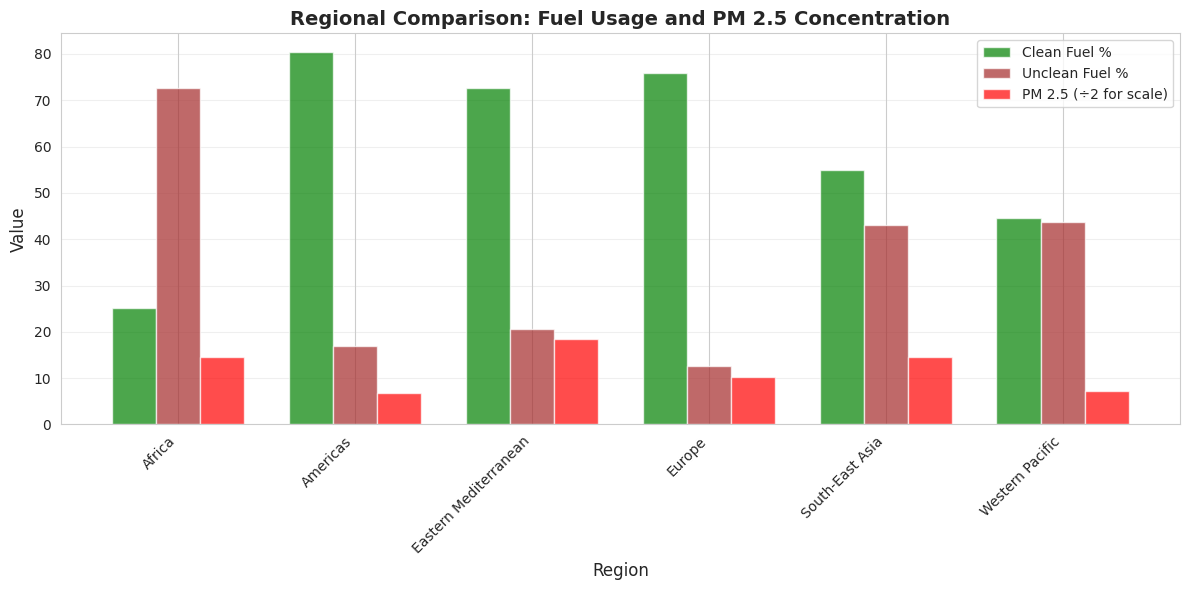

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))
regional_data = merged_df.groupby('Region_x').agg({
    'PM25_Concentration': 'mean',
    'Clean': 'mean',
    'Unclean': 'mean'
}).reset_index()

x = np.arange(len(regional_data))
width = 0.25

ax.bar(x - width, regional_data['Clean'], width, label='Clean Fuel %',
       color='green', alpha=0.7)
ax.bar(x, regional_data['Unclean'], width, label='Unclean Fuel %',
       color='brown', alpha=0.7)
ax.bar(x + width, regional_data['PM25_Concentration']/2, width,
       label='PM 2.5 (÷2 for scale)', color='red', alpha=0.7)

ax.set_xlabel('Region', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.set_title('Regional Comparison: Fuel Usage and PM 2.5 Concentration',
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(regional_data['Region_x'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('regional_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Regional comparison saved as 'regional_comparison.png'")
plt.show()

**Visualization 3: Urban vs Rural Comparison**

✓ Urban/Rural comparison saved as 'urban_rural_comparison.png'


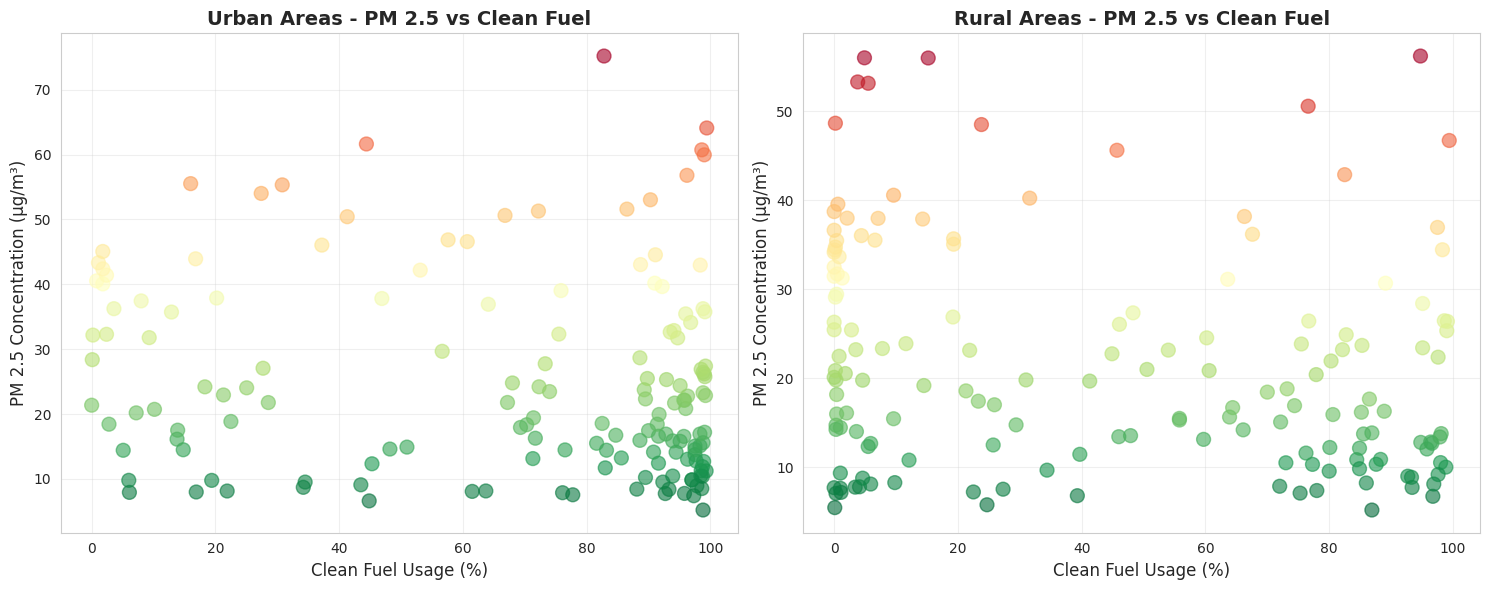

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for idx, residence in enumerate(['Urban', 'Rural']):
    residence_data = merged_df[merged_df['Residence_Type'] == residence]

    if len(residence_data) > 0 and 'Clean' in residence_data.columns:
        axes[idx].scatter(residence_data['Clean'],
                         residence_data['PM25_Concentration'],
                         alpha=0.6, s=100,
                         c=residence_data['PM25_Concentration'],
                         cmap='RdYlGn_r')
        axes[idx].set_xlabel('Clean Fuel Usage (%)', fontsize=12)
        axes[idx].set_ylabel('PM 2.5 Concentration (μg/m³)', fontsize=12)
        axes[idx].set_title(f'{residence} Areas - PM 2.5 vs Clean Fuel',
                           fontsize=14, fontweight='bold')
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('urban_rural_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Urban/Rural comparison saved as 'urban_rural_comparison.png'")
plt.show()



# STEP 6: MACHINE LEARNING ANALYSIS



In [13]:
print("\n\n[STEP 6] MACHINE LEARNING ANALYSIS")
print("-" * 80)

# Prepare features for ML
if 'Clean' in merged_df.columns and 'Unclean' in merged_df.columns:
    ml_df = merged_df[['Clean', 'Unclean', 'PM25_Concentration']].dropna()

    if len(ml_df) > 10:
        X = ml_df[['Clean', 'Unclean']]
        y = ml_df['PM25_Concentration']

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # Linear Regression
        print("\nLinear Regression Model:")
        lr_model = LinearRegression()
        lr_model.fit(X_train, y_train)
        lr_pred = lr_model.predict(X_test)
        lr_r2 = r2_score(y_test, lr_pred)
        lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))

        print(f"  • R² Score: {lr_r2:.4f}")
        print(f"  • RMSE: {lr_rmse:.4f}")
        print(f"  • Clean Fuel Coefficient: {lr_model.coef_[0]:.4f}")
        print(f"  • Unclean Fuel Coefficient: {lr_model.coef_[1]:.4f}")

        # Random Forest
        print("\nRandom Forest Model:")
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_model.fit(X_train, y_train)
        rf_pred = rf_model.predict(X_test)
        rf_r2 = r2_score(y_test, rf_pred)
        rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))

        print(f"  • R² Score: {rf_r2:.4f}")
        print(f"  • RMSE: {rf_rmse:.4f}")
        print(f"  • Feature Importances:")
        for feat, imp in zip(['Clean Fuel', 'Unclean Fuel'],
                            rf_model.feature_importances_):
            print(f"    - {feat}: {imp:.4f}")




[STEP 6] MACHINE LEARNING ANALYSIS
--------------------------------------------------------------------------------

Linear Regression Model:
  • R² Score: 0.0858
  • RMSE: 11.8468
  • Clean Fuel Coefficient: 0.1734
  • Unclean Fuel Coefficient: 0.2176

Random Forest Model:
  • R² Score: -0.3068
  • RMSE: 14.1643
  • Feature Importances:
    - Clean Fuel: 0.5258
    - Unclean Fuel: 0.4742


# STEP 7: COUNTRY-SPECIFIC ANALYSIS

In [14]:
print("\n\n[STEP 7] COUNTRY-SPECIFIC ANALYSIS")
print("-" * 80)

# Top 10 countries by PM 2.5
print("\nTop 10 Countries with Highest PM 2.5 Concentration:")
top_polluted = merged_df.nlargest(10, 'PM25_Concentration')[
    ['Country', 'PM25_Concentration', 'Clean', 'Unclean', 'Residence_Type']
]
print(top_polluted.to_string(index=False))

# Top 10 countries with lowest PM 2.5
print("\n\nTop 10 Countries with Lowest PM 2.5 Concentration:")
top_clean = merged_df.nsmallest(10, 'PM25_Concentration')[
    ['Country', 'PM25_Concentration', 'Clean', 'Unclean', 'Residence_Type']
]
print(top_clean.to_string(index=False))




[STEP 7] COUNTRY-SPECIFIC ANALYSIS
--------------------------------------------------------------------------------

Top 10 Countries with Highest PM 2.5 Concentration:
     Country  PM25_Concentration  Clean  Unclean Residence_Type
 Afghanistan               75.19  82.80     15.0          Urban
       Egypt               64.10  99.40      0.0          Urban
    Cameroon               61.63  44.40     53.9          Urban
Saudi Arabia               60.73  98.60      0.0          Urban
       Qatar               59.96  99.00      0.0          Urban
  Tajikistan               56.80  96.20      1.4          Urban
Saudi Arabia               56.22  94.75      0.3          Rural
     Nigeria               56.02   4.90     93.6          Rural
 Afghanistan               56.00  15.20     83.3          Rural
       Niger               55.52  16.00     82.6          Urban


Top 10 Countries with Lowest PM 2.5 Concentration:
           Country  PM25_Concentration  Clean  Unclean Residence_Type
  

# FINAL SUMMARY

In [15]:
print("\n\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)
print("\nKey Findings:")
print("1. Data processed for 2019 with comprehensive fuel and PM 2.5 coverage")
print("2. Correlation analysis shows relationship between fuel types and air quality")
print("3. Regional and urban/rural patterns identified")
print("4. Machine learning models built to predict PM 2.5 from fuel usage")
print("5. Country-specific comparisons highlight best and worst performers")
print("\nAll visualizations have been saved as PNG files.")
print("=" * 80)



ANALYSIS COMPLETE

Key Findings:
1. Data processed for 2019 with comprehensive fuel and PM 2.5 coverage
2. Correlation analysis shows relationship between fuel types and air quality
3. Regional and urban/rural patterns identified
4. Machine learning models built to predict PM 2.5 from fuel usage
5. Country-specific comparisons highlight best and worst performers

All visualizations have been saved as PNG files.
